In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [26]:
# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

In [27]:
# Normalize and reshape data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [28]:
# Add Gaussian noise to the images
noise_factor = 0.5
x_train_gaussian_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_gaussian_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_gaussian_noisy = np.clip(x_train_gaussian_noisy, 0., 1.)
x_test_gaussian_noisy = np.clip(x_test_gaussian_noisy, 0., 1.)

In [29]:
# Add Salt and Pepper noise to the images
noise_factor = 0.5
img_size = x_test[0].size
noise_size = int(noise_factor * img_size)

x_train_saltpepper_noisy = x_train.copy()
x_test_saltpepper_noisy = x_test.copy()

for i in range(x_train.shape[0]):
  random_indices = np.random.choice(img_size, noise_size)
  noise = np.random.choice([0., 1.], noise_size)
  x_train_saltpepper_noisy[i].flat[random_indices] = noise

for i in range(x_test.shape[0]):
  random_indices = np.random.choice(img_size, noise_size)
  noise = np.random.choice([0., 1.], noise_size)
  x_test_saltpepper_noisy[i].flat[random_indices] = noise

In [30]:
# Add Speckle Noise to the images
noise_factor = 0.5

x_train_speckle_noisy = x_train.copy()
x_test_speckle_noisy = x_test.copy()
for i in range(x_train.shape[0]):
  x_train_speckle_noisy[i] = x_train_speckle_noisy[i] + noise_factor * np.random.rand(28, 28, 1)
  x_train_speckle_noisy[i] = np.clip(x_train_speckle_noisy[i], 0., 1.)

for i in range(x_test.shape[0]):
  x_test_speckle_noisy[i] = x_test_speckle_noisy[i] + noise_factor * np.random.rand(28, 28, 1)
  x_test_speckle_noisy[i] = np.clip(x_test_speckle_noisy[i], 0., 1.)

In [31]:
# Add Poisson Noise to the images
x_train_poisson_noisy = np.random.poisson(x_train)
x_test_poisson_noisy = np.random.poisson(x_test)
x_train_poisson_noisy = x_train_poisson_noisy.astype('float32')
x_test_poisson_noisy = x_test_poisson_noisy.astype('float32')

In [32]:
# Build the Autoencoder network
# Autoencoder consists of an encoder and decoder network
input_shape = (28, 28, 1)
latent_dim = 128

# Encoder
inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, activation='relu', padding='same')(inputs)
x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same')(x)
x = tf.keras.layers.Flatten()(x)
latent_repr = tf.keras.layers.Dense(latent_dim)(x)

# Decoder
x = tf.keras.layers.Dense(7 * 7 * 64)(latent_repr)
x = tf.keras.layers.Reshape((7, 7, 64))(x)
x = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(x)
decoded = tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = tf.keras.models.Model(inputs, decoded)

In [33]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy')

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [35]:
# Train the network with one of the noisy images

x_train_noisy = x_train_poisson_noisy
x_test_noisy = x_test_poisson_noisy

# x_train_noisy = x_train_gaussian_noisy
# x_test_noisy = x_test_gaussian_noisy

# x_train_noisy = x_train_saltpepper_noisy
# x_test_noisy = x_test_saltpepper_noisy

# x_train_noisy = x_train_speckle_noisy
# x_test_noisy = x_test_speckle_noisy

In [36]:
epochs = 20
batch_size = 128

history = autoencoder.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test),
                          epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.3817 - val_loss: 0.1588
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1488 - val_loss: 0.1264
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1236 - val_loss: 0.1142
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1133 - val_loss: 0.1077
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1073 - val_loss: 0.1042
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1040 - val_loss: 0.1018
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1017 - val_loss: 0.1001
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1000 - val_loss: 0.0987
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0985 - val_loss: 0.0976
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0974 - val_loss: 0.0967
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0964 - val_loss: 0.0960
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

In [37]:
def psnr(y_true, y_pred, max_val=1.0):
  """Computes the peak signal-to-noise ratio (PSNR) between two images.

  Args:
    y_true: The ground truth image tensor.
    y_pred: The predicted image tensor.
    max_val: The maximum pixel value in the images.

  Returns:
    The PSNR value as a scalar tensor.
  """

  mse = tf.reduce_mean(tf.square(y_true - y_pred))
  psnr_value = 20 * tf.math.log(max_val / tf.sqrt(mse)) / tf.math.log(10.0)
  return psnr_value

<Figure size 640x480 with 0 Axes>

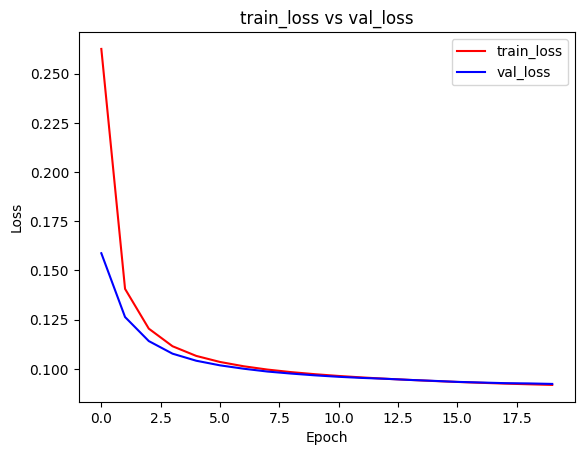

<Figure size 640x480 with 0 Axes>

In [38]:
epochs = range(len(history.history['loss']))

plt.plot(epochs,history.history['loss'],'r', label='train_loss')
plt.plot(epochs,history.history['val_loss'],'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


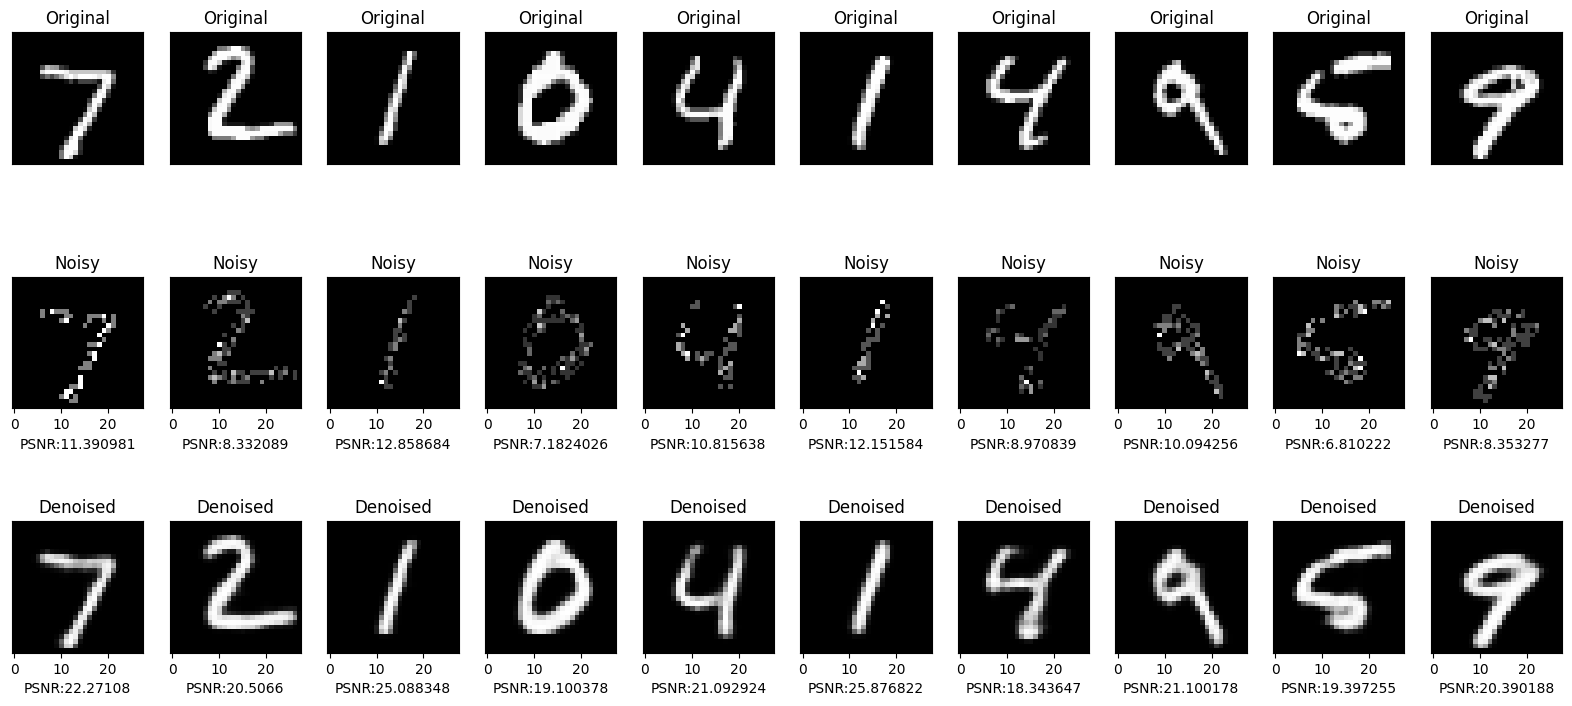

In [39]:
denoised_test_images = autoencoder.predict(x_test_noisy)

# Display original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 9))
sum = 0.0
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    diff = psnr(x_test[i], x_test_noisy[i].astype('float32'))
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(denoised_test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    diff = psnr(x_test[i], denoised_test_images[i])
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

plt.show()

In [40]:
# Compute the PSNR of each denoised image with the original test image
# Accumulate the PSNR of all the denoised images and print the accumulated sum
total_psnr = 0.0
for i in range(x_test_noisy.shape[0]):
  diff = psnr(x_test[i], denoised_test_images[i])
  total_psnr += tf.get_static_value(diff)

print('Total PSNR : ', total_psnr)

Total PSNR :  203267.7439212799


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


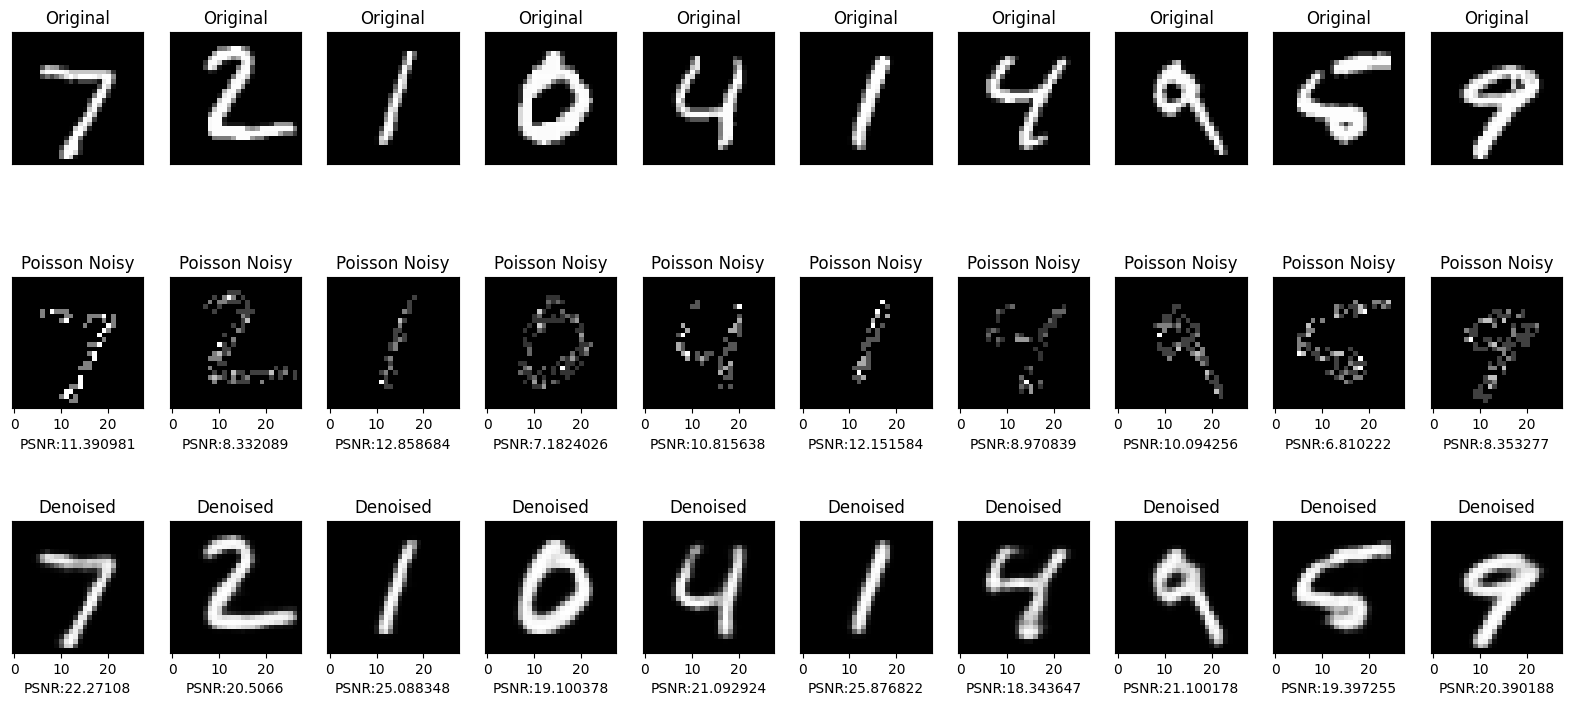

In [41]:
# Train with some noisy images but try denoising poisson noisy images
noisy_images = x_test_poisson_noisy
denoised_test_images = autoencoder.predict(noisy_images)

# Display original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 9))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.title("Poisson Noisy")
    diff = psnr(x_test[i], noisy_images[i].astype('float32'))
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(denoised_test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    diff = psnr(x_test[i], denoised_test_images[i])
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

plt.show()

In [42]:
# Train with some noisy images but try denoising poisson noisy images
# Compute PSNR with the denoising of another noise image
total_psnr = 0.0
for i in range(x_test_noisy.shape[0]):
  diff = psnr(x_test[i], denoised_test_images[i])
  total_psnr += tf.get_static_value(diff)

print('Total PSNR : ', total_psnr)

Total PSNR :  203267.74393081665


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


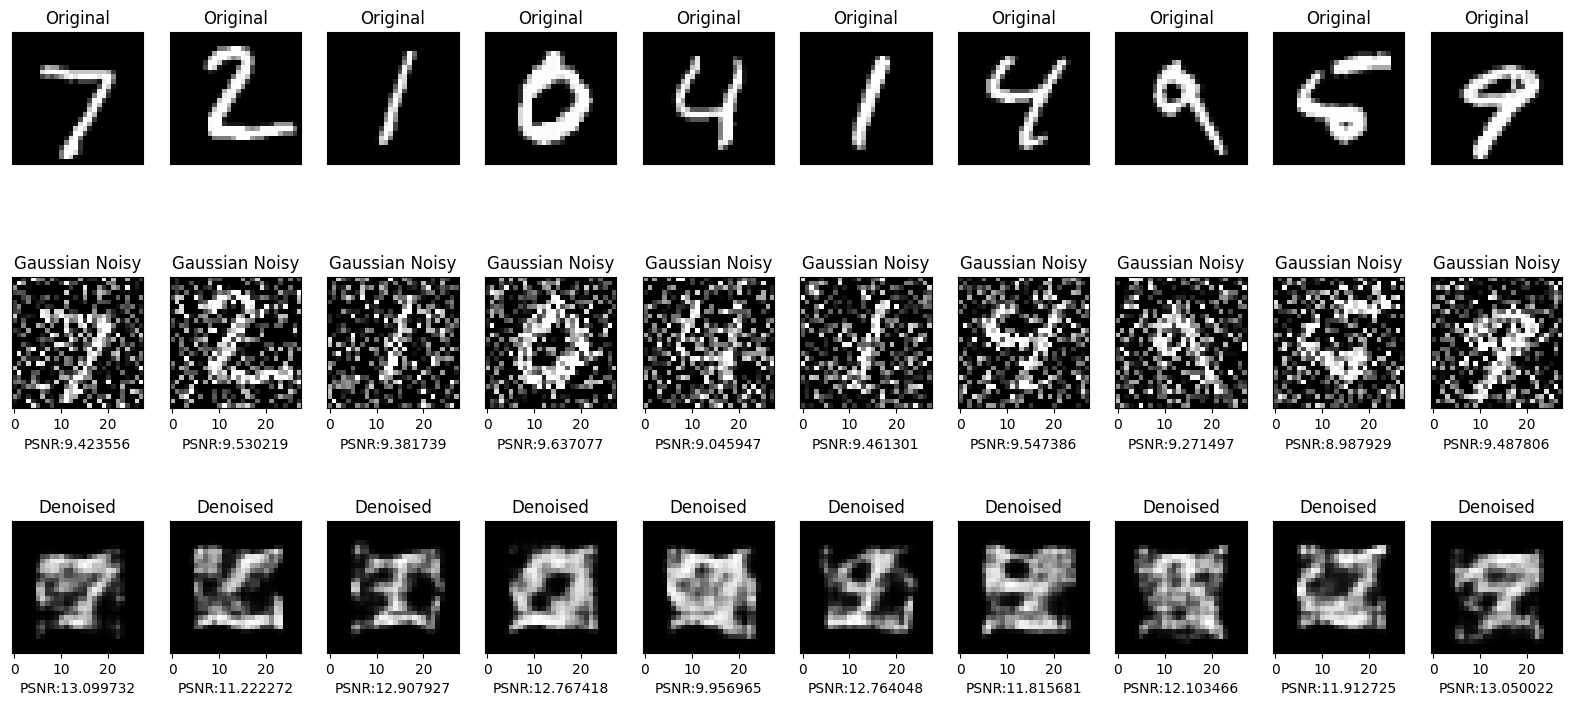

In [43]:
# Train with some noisy images but try denoising Gaussian noisy images
noisy_images = x_test_gaussian_noisy
denoised_test_images = autoencoder.predict(noisy_images)

# Display original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 9))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.title("Gaussian Noisy")
    diff = psnr(x_test[i], noisy_images[i].astype('float32'))
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(denoised_test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    diff = psnr(x_test[i], denoised_test_images[i])
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

plt.show()

In [44]:
# Train with some noisy images but try denoising Gaussian noisy images
# Compute PSNR with the denoising of another noise image
total_psnr = 0.0
for i in range(x_test_noisy.shape[0]):
  diff = psnr(x_test[i], denoised_test_images[i])
  total_psnr += tf.get_static_value(diff)

print('Total PSNR : ', total_psnr)

Total PSNR :  116963.03668880463


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


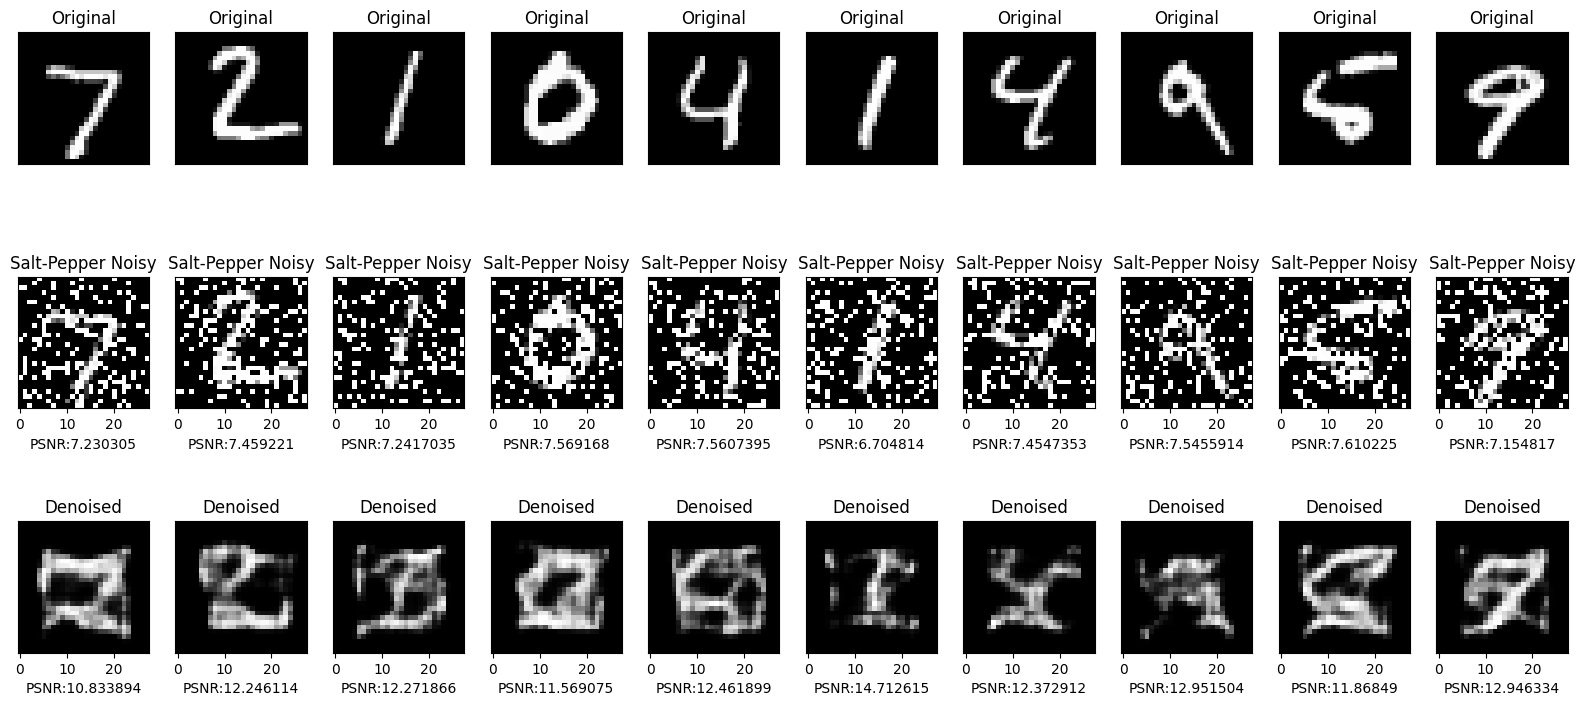

In [45]:
# Train with some noisy images but try denoising Salt-Pepper noisy images
noisy_images = x_test_saltpepper_noisy
denoised_test_images = autoencoder.predict(noisy_images)

# Display original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 9))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.title("Salt-Pepper Noisy")
    diff = psnr(x_test[i], noisy_images[i].astype('float32'))
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(denoised_test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    diff = psnr(x_test[i], denoised_test_images[i])
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

plt.show()

In [46]:
# Train with some noisy images but try denoising Salt-Pepper noisy images
# Compute PSNR with the denoising of another noise image
total_psnr = 0.0
for i in range(x_test_noisy.shape[0]):
  diff = psnr(x_test[i], denoised_test_images[i])
  total_psnr += tf.get_static_value(diff)

print('Total PSNR : ', total_psnr)

Total PSNR :  120650.97545528412


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


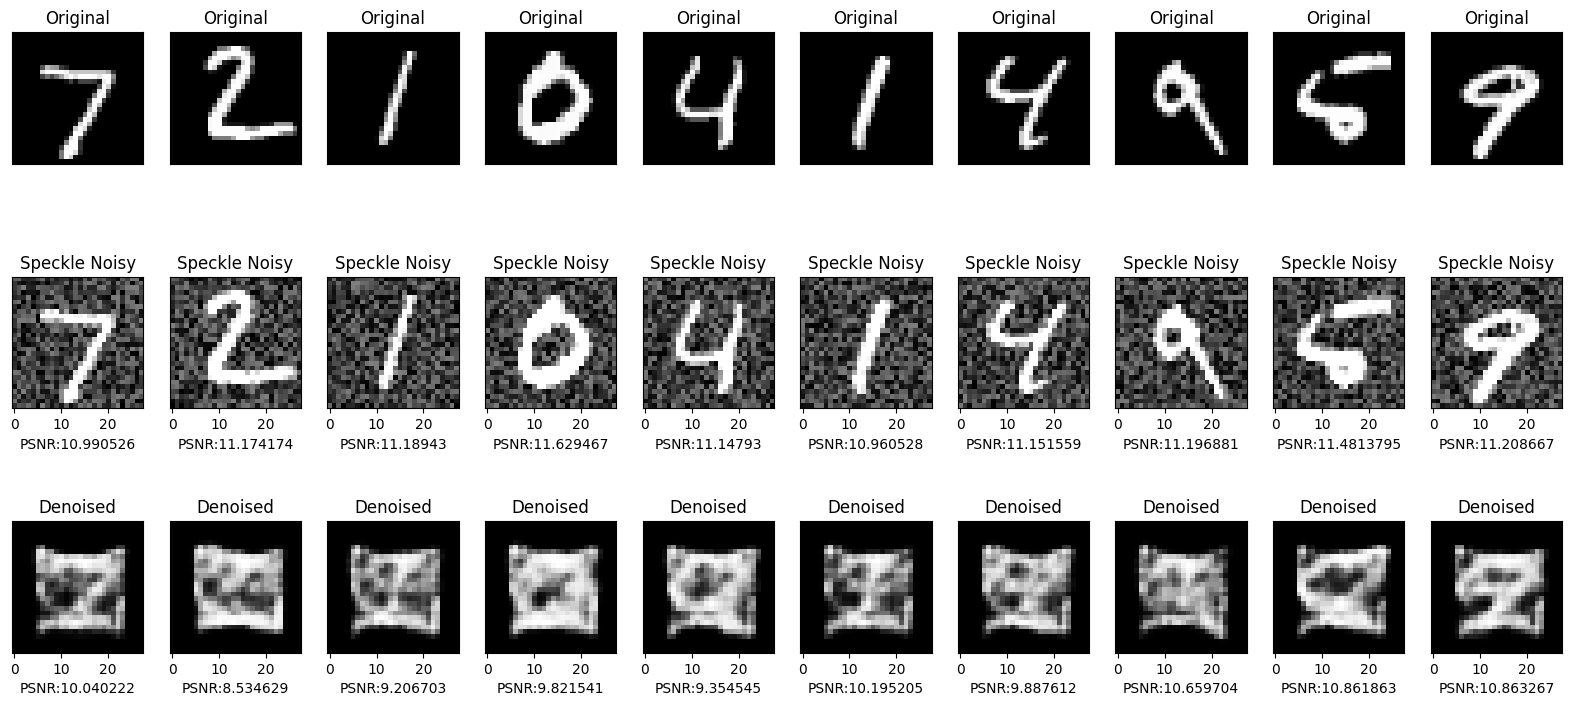

In [47]:
# Train with some noisy images but try denoising Speckle noisy images
noisy_images = x_test_speckle_noisy
denoised_test_images = autoencoder.predict(noisy_images)

# Display original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 9))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.title("Speckle Noisy")
    diff = psnr(x_test[i], noisy_images[i].astype('float32'))
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(denoised_test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    diff = psnr(x_test[i], denoised_test_images[i])
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

plt.show()

In [48]:
# Train with some noisy images but try denoising Speckle noisy images
# Compute PSNR with the denoising of another noise image
total_psnr = 0.0
for i in range(x_test_noisy.shape[0]):
  diff = psnr(x_test[i], denoised_test_images[i])
  total_psnr += tf.get_static_value(diff)

print('Total PSNR : ', total_psnr)

Total PSNR :  97462.25449943542
